In [2]:
pip install pandas pyarrow matplotlib seaborn tqdm PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00


El PDF tiene 305 páginas


Extrayendo texto: 100%|██████████| 305/305 [00:05<00:00, 54.26it/s]


Archivo CSV guardado exitosamente: /content/Los-miserables.csv
El CSV contiene 681 líneas.
Limpiando el texto...
Creando vocabulario...
Total de palabras encontradas: 109502


Procesando palabras: 100%|██████████| 109502/109502 [00:00<00:00, 1846481.90it/s]


Vocabulario creado. Se encontraron 13121 palabras únicas.
Vocabulario guardado en /content/Los-miserables_vocabulario.csv

===== ESTADÍSTICAS DEL TEXTO =====
1. Cantidad de palabras en el texto original: 109502
2. Cantidad de palabras diferentes en el vocabulario: 13121

3. Las 100 palabras más frecuentes:
   1. 'de': 5328 veces
   2. 'la': 3918 veces
   3. 'que': 3818 veces
   4. 'el': 3394 veces
   5. 'y': 3123 veces
   6. 'en': 2836 veces
   7. 'a': 2490 veces
   8. 'se': 1681 veces
   9. 'un': 1601 veces
   10. 'no': 1498 veces
   11. 'los': 1353 veces
   12. 'una': 1319 veces
   13. 'su': 1245 veces
   14. 'por': 936 veces
   15. 'las': 935 veces
   16. 'con': 924 veces
   17. 'habia': 858 veces
   18. 'del': 813 veces
   19. 'al': 756 veces
   20. 'es': 749 veces
   21. 'lo': 719 veces
   22. 'le': 670 veces
   23. 'era': 650 veces
   24. 'como': 572 veces
   25. 'mas': 513 veces
   26. 'para': 504 veces
   27. 'senor': 449 veces
   28. 'esta': 414 veces
   29. 'pero': 372 veces


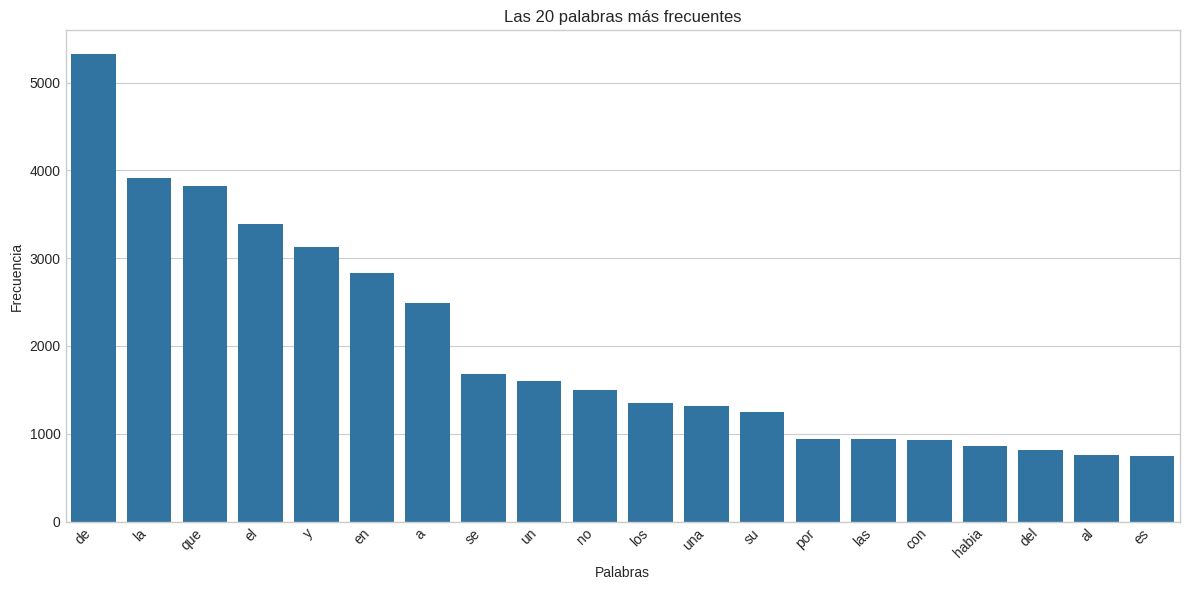

Visualizaciones guardadas como '/content/palabras_frecuentes.png' y '/content/distribucion_frecuencias.png'

¡Proceso completado con éxito!


In [6]:
import PyPDF2
import pandas as pd
import re
import unicodedata
import pyarrow as pa
import pyarrow.parquet as pq
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm


pdf_path = "/content/Los-miserables.pdf"
output_dir = "/content"

def pdf_a_texto(ruta_pdf):

    with open(ruta_pdf, 'rb') as archivo:

        lector_pdf = PyPDF2.PdfReader(archivo)


        num_paginas = len(lector_pdf.pages)
        print(f"El PDF tiene {num_paginas} páginas")


        texto_completo = ""
        for i in tqdm(range(num_paginas), desc="Extrayendo texto"):
            pagina = lector_pdf.pages[i]
            texto_completo += pagina.extract_text() + "\n"
    return texto_completo

def texto_a_csv(texto, ruta_csv):

    lineas = texto.split('\n')


    df = pd.DataFrame({'texto': lineas})

    df.to_csv(ruta_csv, index=False)

    print(f"Archivo CSV guardado exitosamente: {ruta_csv}")
    print(f"El CSV contiene {len(lineas)} líneas.")

    return ruta_csv

def limpiar_texto(texto):
    print("Limpiando el texto...")

    texto = texto.lower()

    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')

    texto = re.sub(r'[^\w\s]', ' ', texto)

    texto = re.sub(r'\d+', ' ', texto)

    texto = re.sub(r'\s+', ' ', texto)

    return texto.strip()

def crear_vocabulario(texto_limpio):

    print("Creando vocabulario...")


    palabras = texto_limpio.split()
    total_palabras = len(palabras)

    print(f"Total de palabras encontradas: {total_palabras}")


    vocabulario = Counter()


    for palabra in tqdm(palabras, desc="Procesando palabras"):

        if not palabra:
            continue

        vocabulario[palabra] += 1

    print(f"Vocabulario creado. Se encontraron {len(vocabulario)} palabras únicas.")
    return vocabulario, total_palabras

def guardar_vocabulario_csv(vocabulario, archivo="vocabulario.csv"):



    df = pd.DataFrame(vocabulario.items(), columns=['palabra', 'frecuencia'])


    df = df.sort_values('frecuencia', ascending=False)


    df.to_csv(archivo, index=False)

    print(f"Vocabulario guardado en {archivo}")

    return df

def guardar_vocabulario_parquet(df, archivo="vocabulario.parquet"):


    tabla = pa.Table.from_pandas(df)


    pq.write_table(tabla, archivo)

def mostrar_estadisticas(total_palabras, vocabulario):

    print("\n===== ESTADÍSTICAS DEL TEXTO =====")


    print(f"1. Cantidad de palabras en el texto original: {total_palabras}")


    palabras_diferentes = len(vocabulario)
    print(f"2. Cantidad de palabras diferentes en el vocabulario: {palabras_diferentes}")

    print("\n3. Las 100 palabras más frecuentes:")
    for i, (palabra, frec) in enumerate(vocabulario.most_common(100), 1):
        print(f"   {i}. '{palabra}': {frec} veces")

    palabras_menos_frecuentes = vocabulario.most_common()[:-101:-1]
    print("\n4. Las 100 palabras menos frecuentes:")
    for i, (palabra, frec) in enumerate(palabras_menos_frecuentes, 1):
        print(f"   {i}. '{palabra}': {frec} veces")


    print("\n===== ESTADÍSTICAS ADICIONALES =====")

    hapax = sum(1 for palabra, frec in vocabulario.items() if frec == 1)
    print(f"Palabras que aparecen solo una vez: {hapax} ({(hapax/palabras_diferentes)*100:.2f}% del vocabulario)")


    freq_dist = Counter(vocabulario.values())
    print("\nDistribución de frecuencias:")
    for frec, cantidad in sorted(freq_dist.items())[:10]:
        print(f"   Frecuencia {frec}: {cantidad} palabras")


    promedio = sum(vocabulario.values()) / len(vocabulario)
    print(f"\nPromedio de repeticiones por palabra: {promedio:.2f}")

def visualizar_estadisticas(vocabulario, n=20, directorio_salida='.'):
    """Crea visualizaciones para las estadísticas del vocabulario."""

    plt.style.use('seaborn-v0_8-whitegrid')


    ruta_frecuentes = os.path.join(directorio_salida, 'palabras_frecuentes.png')
    ruta_distribucion = os.path.join(directorio_salida, 'distribucion_frecuencias.png')

    plt.figure(figsize=(12, 6))
    palabras_top = dict(vocabulario.most_common(n))
    sns.barplot(x=list(palabras_top.keys()), y=list(palabras_top.values()))
    plt.title(f'Las {n} palabras más frecuentes')
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(ruta_frecuentes)


    plt.show()

    print(f"Visualizaciones guardadas como '{ruta_frecuentes}' y '{ruta_distribucion}'")


def procesar_pdf_a_vocabulario(pdf_path, output_dir):

    os.makedirs(output_dir, exist_ok=True)

    nombre_base = os.path.splitext(os.path.basename(pdf_path))[0]
    ruta_csv_texto = os.path.join(output_dir, f"{nombre_base}.csv")
    ruta_csv_vocabulario = os.path.join(output_dir, f"{nombre_base}_vocabulario.csv")
    ruta_parquet_vocabulario = os.path.join(output_dir, f"{nombre_base}_vocabulario.parquet")


    texto = pdf_a_texto(pdf_path)

    texto_a_csv(texto, ruta_csv_texto)


    texto_limpio = limpiar_texto(texto)


    vocabulario, total_palabras = crear_vocabulario(texto_limpio)


    df_vocabulario = guardar_vocabulario_csv(vocabulario, archivo=ruta_csv_vocabulario)


    guardar_vocabulario_parquet(df_vocabulario, archivo=ruta_parquet_vocabulario)


    mostrar_estadisticas(total_palabras, vocabulario)


    visualizar_estadisticas(vocabulario, n=20, directorio_salida=output_dir)

    print("\n¡Proceso completado con éxito!")

    return {
        'texto_csv': ruta_csv_texto,
        'vocabulario_csv': ruta_csv_vocabulario,
        'vocabulario_parquet': ruta_parquet_vocabulario
    }

resultado = procesar_pdf_a_vocabulario(pdf_path, output_dir)